In [1]:
import numpy as np 
import matplotlib.pyplot as plt
from IPython.display import display, Latex

import torch
from torch.utils.data import random_split, DataLoader
import torch.nn as nn
from pytorch_lightning import Trainer

from pytorch_lightning.loggers import TensorBoardLogger
from pytorch_lightning.callbacks.early_stopping import EarlyStopping

from pathlib import Path

from dataset import MushroomBodyDataset 
from rnn import NeuralRNNModule

import json
import pandas as pd

from sklearn.linear_model import LinearRegression 

%load_ext autoreload
%aimport dataset, rnn
%autoreload 1

In [2]:
DATA_DIR = Path('../data')

X_train_file = DATA_DIR / 'X-train-exp-time-series-from-distribution.npy'
Y_train_file = DATA_DIR / 'Y-train-from-distribution.npy'
train_dataset = MushroomBodyDataset(X_train_file, Y_train_file)
print(f'Train dataset size: {len(train_dataset)}')

X_val_file = DATA_DIR / 'X-val-exp-time-series-from-distribution.npy'
Y_val_file = DATA_DIR / 'Y-val-from-distribution.npy'
val_dataset = MushroomBodyDataset(X_val_file, Y_val_file)
print(f'Val dataset size: {len(val_dataset)}')

X_test_file = DATA_DIR / 'X-test-exp-time-series-from-distribution.npy'
Y_test_file = DATA_DIR / 'Y-test-from-distribution.npy'
test_dataset = MushroomBodyDataset(X_test_file, Y_test_file)
print(f'Test dataset size: {len(test_dataset)}')

Train dataset size: 18000
Val dataset size: 4500
Test dataset size: 4500


Datum shape for input and output is (timesteps, neurons): torch.Size([10, 15])


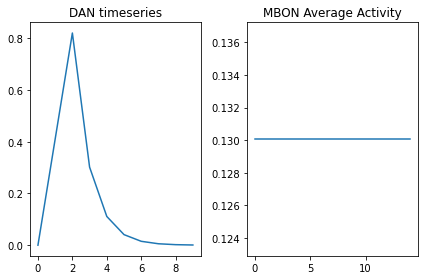

In [3]:
print(f'Datum shape for input and output is (timesteps, neurons): {train_dataset[0]["dan"].shape}')

fig, axs = plt.subplots(1,2)
axs[0].plot(train_dataset[0]["dan"][:,0])
axs[0].set_title('DAN timeseries')
axs[1].plot(train_dataset[0]["mbon"][0] * np.ones(15))
axs[1].set_title('MBON Average Activity')
plt.tight_layout()
plt.show()

In [4]:
all_y_test = []
all_y_test = np.array(all_y_test)

for i in range(len(test_dataset.data)):
    all_y_test = np.concatenate([all_y_test, test_dataset.data[i][1]])

In [5]:
all_y_train = [[] for i in range(15)]
all_y_train = np.array(all_y_train)

for i in range(len(train_dataset.data)):
    all_y_train = np.concatenate([all_y_train, np.expand_dims(train_dataset.data[i][1], axis=1)], axis=1)

In [6]:
all_y_train.shape

(15, 18000)

In [7]:
all_x_train = [[] for i in range(15)]
all_x_train = np.array(all_x_train)

for i in range(len(train_dataset.data)):
    all_x_train = np.concatenate([all_x_train, np.expand_dims(np.mean(train_dataset.data[i][0], axis=0), axis=1)], axis=1)

In [8]:
all_x_train.shape

(15, 18000)

# Pre-train

In [9]:
pre_model_coefs = np.zeros(all_x_train.shape[0])
pre_model_intercepts = np.zeros(all_x_train.shape[0])

for i in range(all_x_train.shape[0]):
    
    # fit canonical model  
    x = all_x_train[i, :]
    y = all_y_train[i, :]
    xT = x.reshape((-1,1))
    pre_model = LinearRegression(fit_intercept=True).fit(xT, y)
    pre_model_coefs[i] = pre_model.coef_
    pre_model_intercepts[i] = pre_model.intercept_

# Hyperparams

In [10]:
hparams = {
    'batch_size': 64,
    'lr': 0.00005,  #used to be 0.00005
    'non_linearity': 'relu',
    'max_epochs': 40,
    'min_epochs': 1
}

# Create Dataloaders

In [11]:
train_dataloader = DataLoader(
    train_dataset, 
    batch_size=hparams['batch_size'],
    shuffle=False, 
    num_workers=4
)

val_dataloader = DataLoader(
    val_dataset, 
    batch_size=hparams['batch_size'],
    shuffle=False, 
    num_workers=4
)

# Load Masks

In [12]:
greek_lobes = [
    r"$\alpha'_1$", r"$\alpha'_2$", r"$\alpha'_3$", 
    r'$\alpha_1$', r'$\alpha_2$', r'$\alpha_3$', 
    r"$\beta'_1$", r"$\beta'_2$",
    r'$\beta_1$', r'$\beta_2$', 
    r'$\gamma_1$', r'$\gamma_2$', r'$\gamma_3$', r'$\gamma_4$', r'$\gamma_5$'
]

In [13]:
def plot_matrix(matrix, labels, title, cbar_title=None, size=[8,8], switch=False):
    fig, ax = plt.subplots(figsize=size)
    im = ax.imshow(matrix)
    
    plt.yticks(range(len(labels)), labels)
    plt.xticks(range(len(labels)), labels)
    plt.title(title)
    
    ax.set_ylim(14.5, -0.5)
    
    if switch:
        plt.xlabel('Target', fontsize=16)
        plt.ylabel('Source', fontsize=16)
    else:
        plt.xlabel('Source')
        plt.ylabel('Target')
    # Loop over data dimensions and create text annotations.
    for i in range(len(labels)):
        for j in range(len(labels)):
            col = 'white' if matrix[i, j] < matrix.max()/2 else 'black'
            text = ax.text(j, i, int(matrix[i, j]),
                           ha="center", va="center", color=col)

    # Create colorbar
    if cbar_title is not None:
        cbar = ax.figure.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
        cbar.ax.set_ylabel(cbar_title, rotation=-90, va="bottom")

    plt.tight_layout()

In [14]:
mbon2mbon_connectome = np.load('../data/mbon-connectomics.npy')

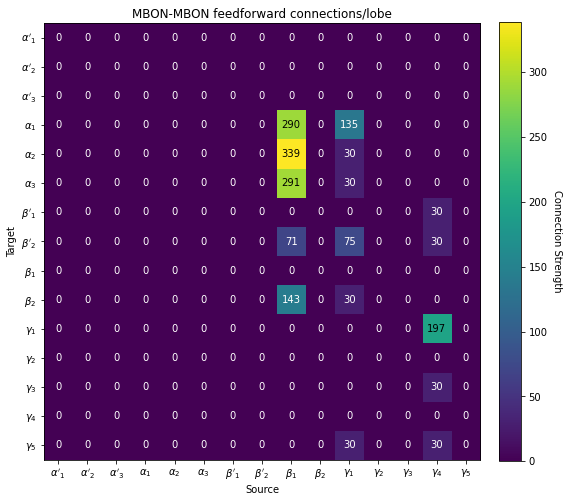

In [15]:
plot_matrix(
    mbon2mbon_connectome, 
    greek_lobes, 
    'MBON-MBON feedforward connections/lobe', 
    'Connection Strength'
)

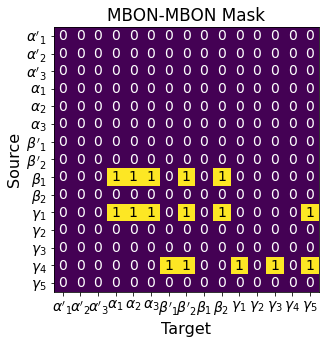

In [16]:
plt.rcParams["font.size"] = 14

mbon_mask = torch.from_numpy((mbon2mbon_connectome > 0)*1.0)
plot_matrix(
    mbon_mask.t(), 
    greek_lobes, 
    'MBON-MBON Mask',
    size=[5,5],
    switch=True
)

# plt.savefig('mbon-mbon-mask.png')

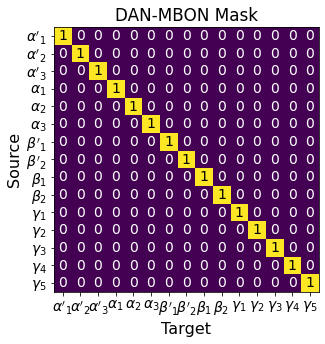

In [17]:
dan_mask = torch.from_numpy(np.diag(np.ones(15)))
plot_matrix(
    dan_mask.t(), 
    greek_lobes, 
    'DAN-MBON Mask',
    size=[5,5],
    switch=True
)

# plt.savefig('dan-mbon-mask.png')

# Instantiate Model

In [18]:
model = NeuralRNNModule(
    masked=True,                           # if using masks for Wxh and Whh
    lr=hparams['lr'],                      # learning rate
    input_mask=dan_mask.t(),               # mask shape (in_dans, out_mbons) = (15,15)
    hidden_mask=mbon_mask.t(),             # mask shape (in_mbons, out_mbons) = (15,15)
    non_linearity=hparams['non_linearity'] # relu or tanh
)

model.hparams

"lr":            5e-05
"masked":        True
"non_linearity": relu

In [19]:
torch.nn.init.constant_(model.rnn.W_hh.weight, 0)
torch.nn.init.constant_(model.rnn.W_hh.bias, 0)
for i in range(15):
    torch.nn.init.constant_(model.rnn.W_xh.bias[i], pre_model_intercepts[i])
    torch.nn.init.constant_(model.rnn.W_xh.weight[i,i], pre_model_coefs[i])

In [20]:
batch = next(iter(train_dataloader))
print(f'Input data shape: {batch["dan"].shape}')
print(f'Output data shape: {batch["mbon"].shape}')

Input data shape: torch.Size([64, 10, 15])
Output data shape: torch.Size([64, 15])


In [21]:
# Check that the forward pass does what I expect
output = model(batch['dan'])
output.shape    # (batch, nodes)

torch.Size([64, 15])

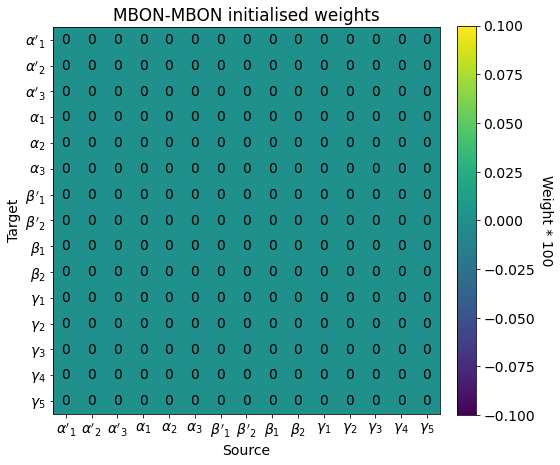

In [22]:
# Check the masked/unmasked weights before training
M = model.rnn.W_hh.weight.detach().numpy() * 100
plot_matrix(
    M, 
    greek_lobes, 
    'MBON-MBON initialised weights', 
    'Weight * 100',
    switch=False
)

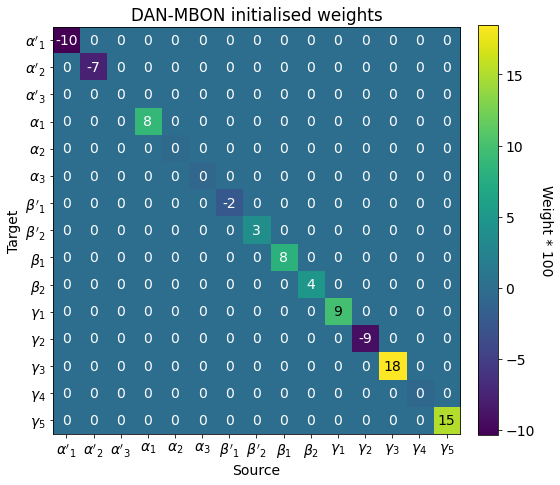

In [23]:
# Check the masked/unmasked weights before training
M = model.rnn.W_xh.weight.detach().numpy() * 100
plot_matrix(
    M, 
    greek_lobes, 
    'DAN-MBON initialised weights', 
    'Weight * 100',
    switch=False
)

# Train model

In [24]:
logger = TensorBoardLogger("tb_logs", name="masked_rnn_average", default_hp_metric=False)

In [25]:
logger.log_hyperparams(hparams)

In [26]:
trainer = Trainer(
    logger=logger,
    max_epochs=hparams['max_epochs'],
    min_epochs=hparams['min_epochs'],
    callbacks=[EarlyStopping(monitor='val/loss')]
)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs


In [27]:
model.rnn.W_xh.bias

Parameter containing:
tensor([0.2895, 0.4148, 0.1679, 0.1789, 0.1861, 0.3197, 0.2797, 0.1502, 0.2219,
        0.1742, 0.2597, 0.3104, 0.2834, 0.2714, 0.0753], requires_grad=True)

In [28]:
trainer.fit(model, train_dataloader, val_dataloader)


  | Name     | Type            | Params
---------------------------------------------
0 | rnn      | MaskedNeuralRNN | 930   
1 | loss_fcn | MSELoss         | 0     
---------------------------------------------
480       Trainable params
450       Non-trainable params
930       Total params
0.004     Total estimated model params size (MB)


Adjusting learning rate of group 0 to 5.0000e-05.


Validation sanity check: 0it [00:00, ?it/s]

Training: -1it [00:00, ?it/s]

Adjusting learning rate of group 0 to 5.0000e-05.


Validating: 0it [00:00, ?it/s]

Adjusting learning rate of group 0 to 5.0000e-05.


Validating: 0it [00:00, ?it/s]

Adjusting learning rate of group 0 to 5.0000e-05.


Validating: 0it [00:00, ?it/s]

Adjusting learning rate of group 0 to 5.0000e-05.


Validating: 0it [00:00, ?it/s]

# Save model

In [29]:
MODEL_PATH = Path('../models/masked_rnn_av.pt')

torch.save(model.state_dict(), MODEL_PATH)

# Load model (optional)

In [30]:
# Load model for inference using:

MODEL_PATH = Path('../models/masked_rnn_av.pt')
model = NeuralRNNModule(
    masked=True,                           # if using masks for Wxh and Whh
    lr=hparams['lr'],                      # learning rate
    input_mask=dan_mask.t(),               # mask shape (in_dans, out_mbons) = (15,15)
    hidden_mask=mbon_mask.t(),             # mask shape (in_mbons, out_mbons) = (15,15)
    non_linearity=hparams['non_linearity'] # relu or tanh
)
model.load_state_dict(torch.load(MODEL_PATH))
model.eval()

NeuralRNNModule(
  (rnn): MaskedNeuralRNN(
    (W_xh): CustomizedLinear(input_features=15, output_features=15, bias=True)
    (W_hh): CustomizedLinear(input_features=15, output_features=15, bias=True)
    (activation): ReLU()
  )
  (loss_fcn): MSELoss()
)

# Visualise the trained weights

In [31]:
def normalise(m):
    if m.min() < 0:
        return (m - m.min() )/ (m.max() - m.min())
    
    if m.max() > 0:
        return m / m.max()
    else:
        return m

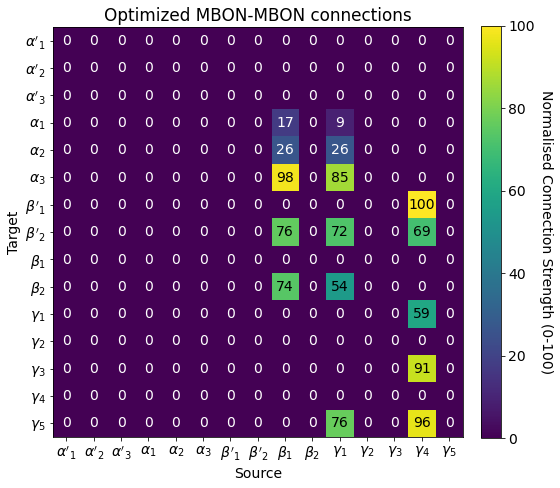

In [32]:
# multiply by 100 for visulisation purposes
M = model.rnn.W_hh.weight.detach().numpy()

# We are examing the number of synapses - so positive or negative is weights are not NB
M = np.abs(M)
M = normalise(M) * 100
plot_matrix(
    M, 
    greek_lobes, 
    'Optimized MBON-MBON connections', 
    'Normalised Connection Strength (0-100)'
)
plt.savefig('constrained_rnn_mbon_mbon_matrix.png',transparent=True)

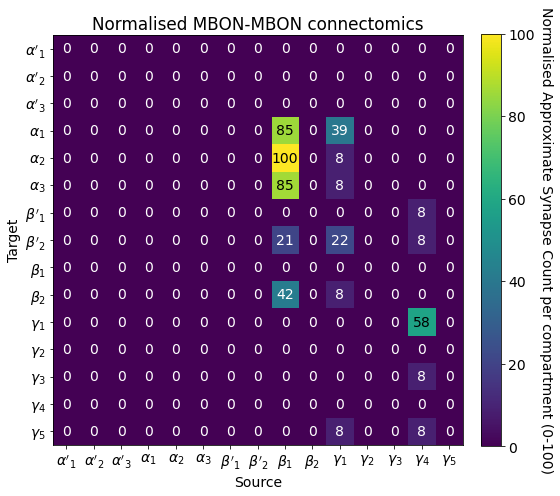

In [33]:
# multiply by 100 for visulisation purposes
M = normalise(mbon2mbon_connectome) * 100
plot_matrix(
    M, 
    greek_lobes, 
    'Normalised MBON-MBON connectomics', 
    'Normalised Approximate Synapse Count per compartment (0-100)'
)

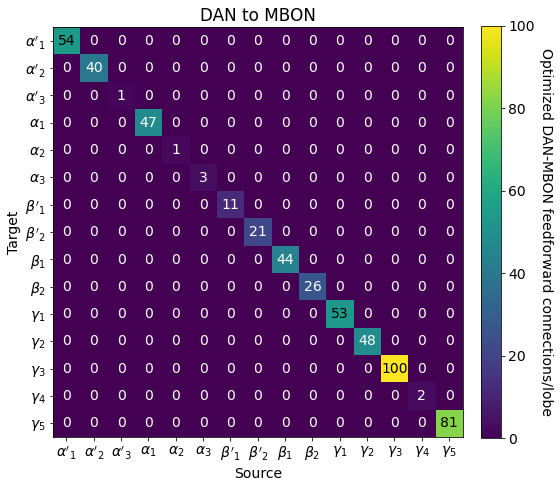

In [34]:
# multiply by 100 for visulisation purposes
M = normalise(
        np.abs(model.rnn.W_xh.weight.detach().numpy())
    )* 100
plot_matrix(
    M, 
    greek_lobes, 
    'DAN to MBON', 
    'Optimized DAN-MBON feedforward connections/lobe'
)
plt.savefig('constrained_rnn_dan_mbon_matrix.png', transparent=True)

# Inspect shape of the output

In [35]:
 model.eval()

NeuralRNNModule(
  (rnn): MaskedNeuralRNN(
    (W_xh): CustomizedLinear(input_features=15, output_features=15, bias=True)
    (W_hh): CustomizedLinear(input_features=15, output_features=15, bias=True)
    (activation): ReLU()
  )
  (loss_fcn): MSELoss()
)

In [36]:
test_dataloader = DataLoader(
    test_dataset, 
    batch_size=1,
    shuffle=False, 
    num_workers=4
)

batch = next(iter(val_dataloader))
output = model(batch['dan'])
output_ts = model.rnn(batch['dan'])[0]

print(output.shape, output_ts.shape)

torch.Size([64, 15]) torch.Size([64, 10, 15])


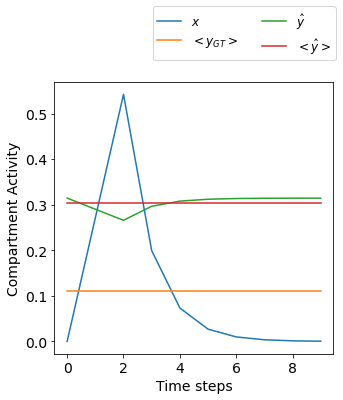

In [37]:
compartment = 11
idx = 5

pred = output[idx,compartment].detach().numpy()
pred_ts = output_ts[idx,:,compartment].detach().numpy()


plt.figure(figsize=[5,5])
plt.plot(batch['dan'][idx,:,compartment], label=r'$x$') # dan activity
plt.plot(batch['mbon'][idx,compartment] * np.ones(10), label=r'$<y_{GT}>$') # actual mean
plt.plot(pred_ts, label=r'$ \hat y$')             # predicted time series
plt.plot(pred * np.ones(10), label=r'$<\hat y>$') # predicted mean

plt.xlabel('Time steps')
plt.ylabel('Compartment Activity')

plt.legend(fontsize=12, ncol=2, loc='upper right', bbox_to_anchor=(1.03, 1.3))

plt.savefig('masked-recurrent-predicted-activity.png', bbox_inches='tight')
plt.show()

# Testing

In [38]:
model.eval()

test_dataloader = DataLoader(
    test_dataset, 
    batch_size=1,
    shuffle=False, 
    num_workers=4
)

In [39]:
gt = []
pred = []

test_loss = 0
for batch in test_dataloader:
    x = batch['dan']
    y = batch['mbon']
    y_pred = model(x)

    gt.append(y.detach().numpy().squeeze())
    pred.append(y_pred.squeeze().detach().numpy())

    
gt = np.array(gt)
pred = np.array(pred)

gt.shape, pred.shape

((4500, 15), (4500, 15))

In [40]:
model.rnn.W_xh.bias

Parameter containing:
tensor([0.2917, 0.4174, 0.1707, 0.1787, 0.1868, 0.3220, 0.2821, 0.1521, 0.2233,
        0.1760, 0.2612, 0.3124, 0.2857, 0.2716, 0.0776], requires_grad=True)

## MSE

In [41]:
mse = np.sum((gt - pred) ** 2, axis = 0)/ gt.shape[0]
mse.mean()

0.010807199

In [42]:
lobes = np.array(["alpha'1", "alpha'2", "alpha'3", 'alpha1', 'alpha2', 'alpha3',
       "beta'1", "beta'2", 'beta1', 'beta2', 'gamma1', 'gamma2', 'gamma3',
       'gamma4', 'gamma5'])

mse_rnn = {}

for i, lobe in enumerate(lobes):
    mse_rnn[lobe] = mse[i]

## Compare MSE with linear models

In [43]:
RESULTS_DIR = Path('../results')

with open( RESULTS_DIR / 'canonical_linear_model_testing_data_mse.json', "r") as file:
    mse_canonical = json.load(file)

with open( RESULTS_DIR / 'crossed_linear_model_testing_data_mse.json', "r") as file:
    mse_crossed = json.load(file)
    
mse_df = pd.concat(
    [
        pd.Series(mse_canonical, name='Canonical Linear'), 
        pd.Series(mse_crossed, name='Dense Linear'),
        pd.Series(mse_rnn, name='Masked RNN') 
    ],
    axis=1
)


mse_df.describe()

,Canonical Linear,Dense Linear,Masked RNN
count,15.000000,15.000000,15.000000
mean,0.010792,0.009710,0.010807
std,0.011766,0.010646,0.011752
min,0.001796,0.001636,0.001829
25%,0.003339,0.003185,0.003347
50%,0.008031,0.006812,0.008077
75%,0.014140,0.012193,0.014160
max,0.047920,0.043491,0.047887


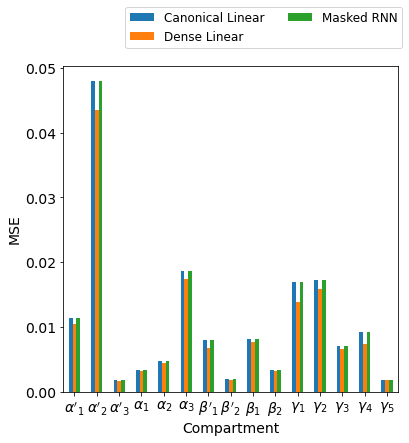

In [44]:
mse_df["lobe"] = mse_df.index


mse_df["lobe"] = mse_df.index

mse_df.plot(x="lobe", y=["Canonical Linear", "Dense Linear", "Masked RNN"], kind="bar", figsize=[6,6])
plt.xlabel('Compartment')
plt.ylabel('MSE')

plt.xticks(range(15), greek_lobes, rotation=0)

plt.legend(fontsize=12, ncol=2, loc='upper right', bbox_to_anchor=(1.03, 1.2))

plt.savefig('comparison-mse-masked.png', bbox_inches='tight')

plt.show()

## R-squared

In [45]:
# calculate the r^2 for each output
# use this formula https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html#sklearn.linear_model.LinearRegression.score
# 1 - (residual sum of squares) / (total sum of squares)

# total sum of squares: remove mean, square and sum
tss = np.sum((gt - gt.mean(axis=0))**2, axis=0)

# risidual sum of squares or the sum of residual errors
rss = np.sum((gt - pred)**2, axis =0)

r_squared = 1 - rss / tss

In [46]:
r_squared_rnn = {}

for i, lobe in enumerate(lobes):
    r_squared_rnn[lobe] = r_squared[i]

In [47]:
RESULTS_DIR = Path('../results')

with open( RESULTS_DIR / 'canonical_linear_model_testing_data_rsquared.json', "r") as file:
    rsquared_canonical = json.load(file)

with open( RESULTS_DIR / 'crossed_linear_model_testing_data_rsquared.json', "r") as file:
    rsquared_crossed = json.load(file)
    
rsquared_df = pd.concat(
    [
        pd.Series(rsquared_canonical, name='Canonical Linear'), 
        pd.Series(rsquared_crossed, name='Dense Linear'),
        pd.Series(r_squared_rnn, name='Masked RNN') 
    ],
    axis=1
)


rsquared_df.describe()

,Canonical Linear,Dense Linear,Masked RNN
count,15.000000,15.000000,15.000000
mean,0.009303,0.096668,0.004631
std,0.019015,0.051218,0.019272
min,-0.001501,0.032774,-0.019119
25%,0.000299,0.064098,-0.000813
50%,0.004477,0.079877,0.000219
75%,0.006286,0.118251,0.005666
max,0.073847,0.205374,0.069019


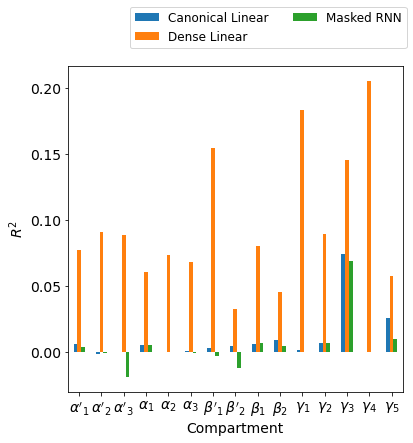

In [48]:


rsquared_df["lobe"] = rsquared_df.index

rsquared_df.plot(x="lobe", y=["Canonical Linear", "Dense Linear", "Masked RNN"], kind="bar", figsize=[6,6])
plt.xlabel('Compartment')
plt.ylabel(r'$R^2$')
plt.xticks(range(15), greek_lobes, rotation=0)
plt.legend(fontsize=12, ncol=2, loc='upper right', bbox_to_anchor=(1.03, 1.2))

plt.savefig('comparison-r2-masked.png', bbox_inches='tight')

plt.show()